In [1]:
%%capture
!pip install laspy
!pip install rasterio

Đang trích xuất đặc trưng từ dữ liệu huấn luyện...
Đang trích xuất đặc trưng từ dữ liệu kiểm tra...
Phân phối lớp trong tập huấn luyện:
type
0    121
1    116
Name: count, dtype: int64
Đang tối ưu siêu tham số...
Best parameters: {'stacking__xgb__n_estimators': 200, 'stacking__xgb__max_depth': 7, 'stacking__xgb__learning_rate': 0.2, 'stacking__lgbm__n_estimators': 100, 'stacking__lgbm__max_depth': 7, 'stacking__catboost__iterations': 300, 'stacking__catboost__depth': 8}

Đánh giá cross-validation:
Độ chính xác trung bình: 0.8526 ± 0.0340

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        30
           1       0.87      0.87      0.87        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60


Báo cáo với ngưỡng tối ưu:
              precision    recall  f1-score   support

           0       0.96   

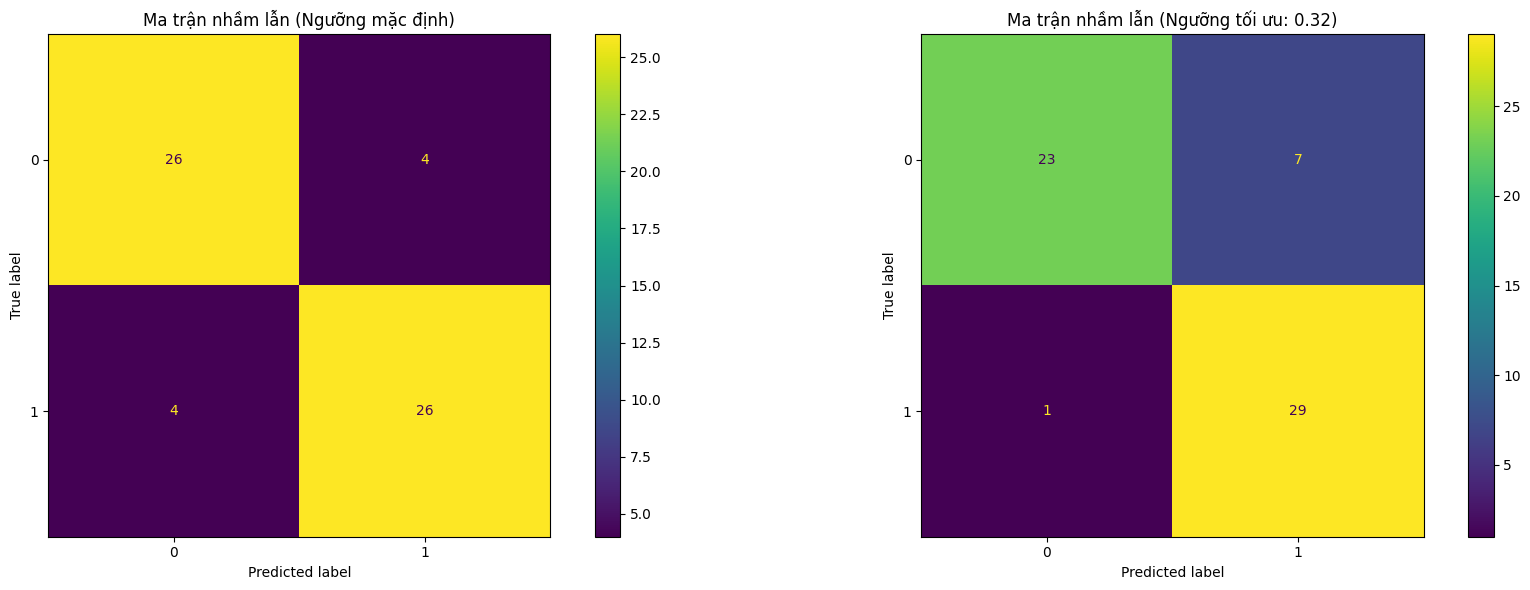

Không thể trích xuất feature importance: All arrays must be of the same length

Phân phối lỗi theo loài:
species
Aspen     3
Pine      2
Spruce    1
Tilia     1
Fir       1
Name: count, dtype: int64


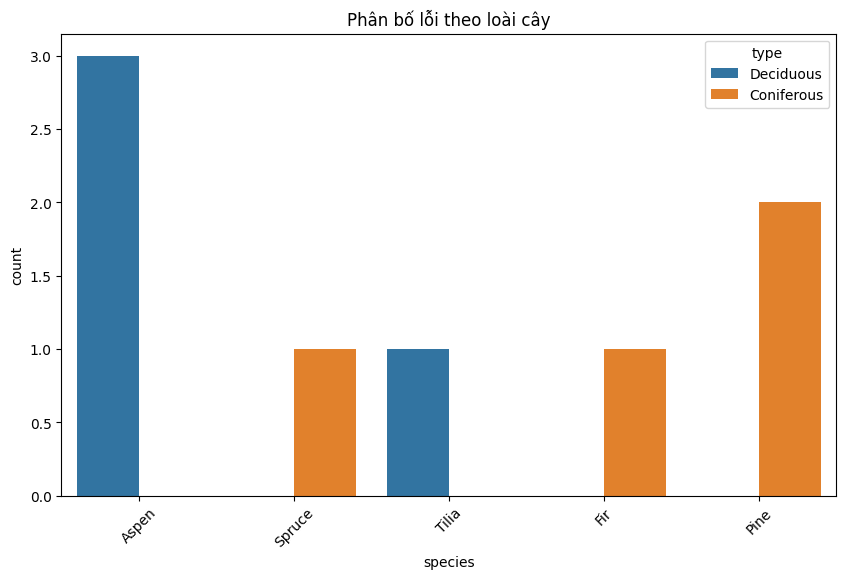

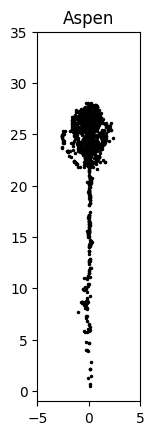

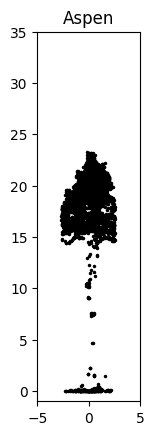

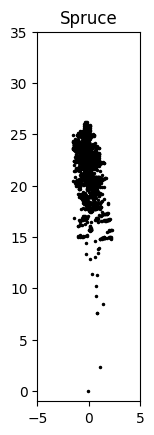

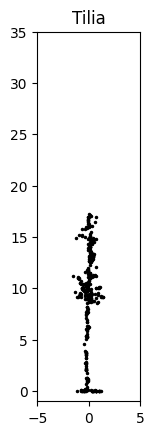

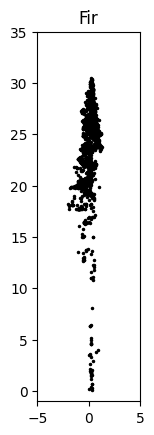

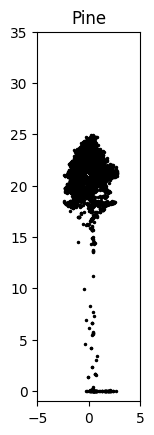

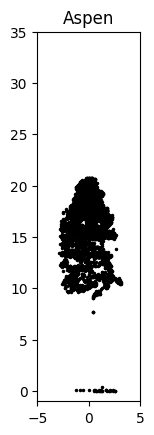

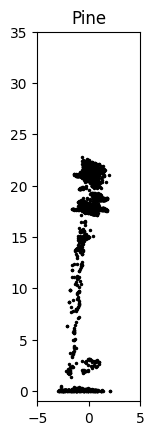


Kết quả dự đoán:
            name  label
56  alder_20.las      1
59  alder_21.las      1
55  alder_22.las      1
57  alder_23.las      1
54  alder_24.las      1


In [2]:

import os
import numpy as np
import pandas as pd
import laspy
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

# Hàm trích xuất đặc trưng từ file .las
def compute_cloud_features(path: str, *, height_threshold: float = 1.0) -> dict:
    las = laspy.read(path)
    out = {}
    
    X, Y, Z = np.rollaxis(las.xyz, axis=1)
    height_mask = Z > height_threshold
    X, Y, Z = X[height_mask], Y[height_mask], Z[height_mask]
    
    # Đặc trưng phân phối chiều cao
    stats = {
        "z_max": Z.max(),
        "z_mean": Z.mean(),
        "z_std": Z.std(),
        "z_skew": scipy.stats.skew(Z),
        "z_kurt": scipy.stats.kurtosis(Z),
        "z_entropy": scipy.stats.entropy(Z + 1e-10),
        "pct_z_above_mean": np.mean(Z > Z.mean()),
        "pct_z_above_2": np.mean(Z > 2),
    }
    
    # Phân vị và tỷ lệ tích lũy
    percentiles = np.percentile(Z, range(10, 100, 10))
    counts, _ = np.histogram(Z, bins=np.linspace(Z.min(), Z.max(), 11))
    cum_ratios = np.cumsum(counts / Z.size)[:-1]
    
    for i, (z, ratio) in enumerate(zip(percentiles, cum_ratios), 1):
        stats.update({
            f"z_decile_{i}": z,
            f"z_cumrat_{i}": ratio
        })
    
    # Đặc trưng hình dạng
    covariance_matrix = np.cov(np.vstack((X, Y, Z)))
    eigenvalues = np.linalg.eigvalsh(covariance_matrix)[::-1]
    lambda1, lambda2, lambda3 = eigenvalues
    
    shape_features = {
        "linearity": (lambda1 - lambda2) / (lambda1 + 1e-10),
        "planarity": (lambda2 - lambda3) / (lambda1 + 1e-10),
        "scatter": lambda3 / (lambda1 + 1e-10),
        "omnivariance": np.cbrt(lambda1 * lambda2 * lambda3),
        "eigentropy": -sum(e * np.log(e + 1e-10) for e in eigenvalues),
        "sum_of_eigenvalues": eigenvalues.sum(),
        "curvature": lambda3 / (eigenvalues.sum() + 1e-10),
    }
    
    return {**stats, **shape_features}

# Hàm tạo DataFrame từ thư mục
def create_feature_dataframe(folder, label_map):
    data = []
    file_paths = []
    
    for class_name, label in label_map.items():
        class_folder = os.path.join(folder, class_name)
        if not os.path.exists(class_folder):
            print(f"Warning: Thư mục {class_folder} không tồn tại.")
            continue
            
        for sub_class in os.listdir(class_folder):
            sub_class_path = os.path.join(class_folder, sub_class)
            if not os.path.isdir(sub_class_path):
                continue
                
            for file in os.listdir(sub_class_path):
                if file.endswith(".las"):
                    file_path = os.path.join(sub_class_path, file)
                    try:
                        features = compute_cloud_features(file_path)
                        features.update({"name": file, "label": label})
                        data.append(features)
                        file_paths.append(file_path)
                    except Exception as e:
                        print(f"Lỗi xử lý {file_path}: {str(e)}")
    
    # Tạo DataFrame
    df = pd.DataFrame(data)
    path_df = pd.DataFrame({"path": file_paths})
    path_df["species"] = path_df["path"].str.split("/").str[-2]
    conifers = {"Spruce", "Fir", "Pine"}
    path_df["type"] = path_df["species"].map(lambda x: "Coniferous" if x in conifers else "Deciduous")
    
    return pd.concat([path_df, df], axis=1).reset_index(drop=True)

# Khởi tạo đường dẫn và nhãn
TRAIN_FOLDER = "/kaggle/input/hutechaichallenge2024-bc/Train"
TEST_FOLDER = "/kaggle/input/hutechaichallenge2024-bc/Test"
label_map = {"Coniferous": 0, "Deciduous": 1}

# Kiểm tra đường dẫn
if not os.path.exists(TRAIN_FOLDER):
    raise FileNotFoundError(f"Thư mục {TRAIN_FOLDER} không tồn tại.")
if not os.path.exists(TEST_FOLDER):
    raise FileNotFoundError(f"Thư mục {TEST_FOLDER} không tồn tại.")

# Tạo DataFrame
print("Đang trích xuất đặc trưng từ dữ liệu huấn luyện...")
train_df = create_feature_dataframe(TRAIN_FOLDER, label_map)
print("Đang trích xuất đặc trưng từ dữ liệu kiểm tra...")
test_df = create_feature_dataframe(TEST_FOLDER, label_map)

# Chuẩn bị dữ liệu
X = train_df.drop(columns=["label", "name", "path", "species", "type"])
y = train_df["type"].map({"Coniferous": 0, "Deciduous": 1})

# Xử lý giá trị đặc biệt
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# Chia tập dữ liệu
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df["species"]
)

# Kiểm tra phân phối lớp
print("Phân phối lớp trong tập huấn luyện:")
print(y_train.value_counts())

# Tạo pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('stacking', StackingClassifier(
        estimators=[
            ('xgb', XGBClassifier()),
            ('lgbm', LGBMClassifier()),
            ('catboost', CatBoostClassifier(verbose=0))
        ],
        final_estimator=RandomForestClassifier(n_estimators=50),  # Sử dụng RandomForest để hỗ trợ feature_importances_
        n_jobs=-1
    ))
])

# Tối ưu siêu tham số
param_dist = {
    'stacking__xgb__n_estimators': [100, 200, 300],
    'stacking__xgb__max_depth': [3, 5, 7],
    'stacking__xgb__learning_rate': [0.01, 0.1, 0.2],
    'stacking__lgbm__n_estimators': [50, 100, 150],
    'stacking__lgbm__max_depth': [3, 5, 7],
    'stacking__catboost__iterations': [100, 200, 300],
    'stacking__catboost__depth': [4, 6, 8],
}

random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=20,  # Tăng số lần thử nghiệm
    cv=5,       # Tăng số fold cross-validation
    scoring='accuracy', 
    n_jobs=-1
)

print("Đang tối ưu siêu tham số...")
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)

# Huấn luyện mô hình với siêu tham số tối ưu
best_pipeline = random_search.best_estimator_
best_pipeline.fit(X_train, y_train)

# Cross-validation
print("\nĐánh giá cross-validation:")
cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Độ chính xác trung bình: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Dự đoán và đánh giá
y_pred = best_pipeline.predict(X_val)
y_proba = best_pipeline.predict_proba(X_val)[:, 1]

print("\nBáo cáo phân loại:")
print(classification_report(y_val, y_pred))

# Tối ưu ngưỡng
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_tuned = (y_proba >= best_threshold).astype(int)

print("\nBáo cáo với ngưỡng tối ưu:")
print(classification_report(y_val, y_pred_tuned))

# Trực quan hóa
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred, ax=ax[0])
ax[0].set_title("Ma trận nhầm lẫn (Ngưỡng mặc định)")

ConfusionMatrixDisplay.from_predictions(y_val, y_pred_tuned, ax=ax[1])
ax[1].set_title(f"Ma trận nhầm lẫn (Ngưỡng tối ưu: {best_threshold:.2f})")

plt.tight_layout()
plt.show()

# Phân tích đặc trưng
try:
    final_model = best_pipeline.named_steps['stacking'].final_estimator_

    if hasattr(final_model, 'feature_importances_'):
        importances = final_model.feature_importances_
    else:
        raise ValueError("Final estimator không hỗ trợ feature importance")

    # Tạo DataFrame
    fi_df = pd.DataFrame({'Đặc trưng': X.columns, 'Độ quan trọng': importances})
    fi_df = fi_df.sort_values('Độ quan trọng', ascending=False).head(15)

    # Visualization
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Độ quan trọng', y='Đặc trưng', data=fi_df, palette='viridis')
    plt.title('Top 15 Đặc Trưng Quan Trọng Nhất')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.show()
except Exception as e:
    print(f"Không thể trích xuất feature importance: {str(e)}")

# Phân tích mẫu sai
wrong_mask = y_pred != y_val
wrong_samples = train_df.loc[X_val.index[wrong_mask]]

if not wrong_samples.empty:
    print("\nPhân phối lỗi theo loài:")
    print(wrong_samples['species'].value_counts())
    
    plt.figure(figsize=(10, 6))
    sns.countplot(data=wrong_samples, x='species', hue='type')
    plt.title('Phân bố lỗi theo loài cây')
    plt.xticks(rotation=45)
    plt.show()

    # Trực quan hóa các mẫu bị phân loại sai
    paths = X_val[wrong_mask].join(train_df, lsuffix="_left", rsuffix="_right")["path"].tolist()
    gt = X_val[wrong_mask].join(train_df, lsuffix="_left", rsuffix="_right")["species"].tolist()

    for path, species in zip(paths, gt):
        las = laspy.read(path)
        xx, yy, zz = np.rollaxis(las.xyz, axis=1)

        height_mask = zz > 0.02
        xx, yy, zz = xx[height_mask], yy[height_mask], zz[height_mask]

        fig, ax = plt.subplots()
        ax.plot(xx - xx.mean(), zz, marker=".", linestyle="", markersize=3, color="k")
        ax.set_aspect("equal")
        ax.set_title(species)
        ax.set_ylim(-1, 35)
        ax.set_xlim(-5, 5)
        plt.show()
else:
    print("\nKhông có mẫu nào bị dự đoán sai!")

# Xuất kết quả dự đoán thành file CSV
test_features = test_df.drop(columns=["name", "path", "species", "type", "label"])
test_features = test_features[X_train.columns]  # Đảm bảo thứ tự và tên cột khớp với X_train
test_predictions = best_pipeline.predict(test_features)

# Tạo DataFrame với tên tệp và nhãn dự đoán
submission = pd.DataFrame({
    "name": test_df["name"],  # Tên tệp
    "label": test_predictions  # Nhãn dự đoán (0: lá kim, 1: lá rộng)
})

# Sắp xếp DataFrame theo cột 'name' để đảm bảo thứ tự giống file mẫu
submission = submission.sort_values(by="name")

# Lưu DataFrame thành file CSV
submission.to_csv("submission.csv", index=False)

# In ra 5 dòng đầu tiên của file CSV để kiểm tra
print("\nKết quả dự đoán:")
print(submission.head())